In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import yfinance as yf
from sklearn.cluster import KMeans

import seaborn as sns
sns.set(style='darkgrid')
import plotly.graph_objects as go

import sys
sys.path.append('../src') 

from scipy.stats import norm
from scipy.optimize import minimize

In [2]:
from kneed import KneeLocator

def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

def identify_weak_support_resistance(data):
    # Initialize an empty list to store the labels (support, resistance, neither)
    labels = []

    # Iterate through the dataframe to identify weak support and weak resistance
    for i in range(len(data)):
        if i == 0 or i == len(data) - 1:
            # Edge cases where there's no previous or following day
            labels.append("neither")
        elif data['close'][i] < data['close'][i - 1] and data['close'][i] < data['close'][i + 1]:
            # Weak support condition
            labels.append("weak support")
        elif data['close'][i] > data['close'][i - 1] and data['close'][i] > data['close'][i + 1]:
            # Weak resistance condition
            labels.append("weak resistance")
        else:
            # Neither weak support nor weak resistance
            labels.append("neither")

    # Add the labels to a new column in the dataframe
    data['Support/Resistance'] = labels

    return data

In [3]:
def plot_stock(stock_name,
               start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'),
               end=datetime.today(),
               figsize=(12, 6),
               interactive=False,
               return_result=False,
              ):
    '''
    Input:
    stock_name: str
    start: datetime
    end: datetime
    '''
    df = yf.download(stock_name.upper(),
                     start=start,
                     end=end)
    df = df.reset_index()
    df.columns = df.columns.str.lower()

    df['20 Day MA'] = df['close'].rolling(window=20).mean()
    df['20 Day STD'] = df['close'].rolling(window=20).std()
    
    # Calculate upper and lower bands
    df['Upper Band'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    close = df.iloc[-1]['close']
    print('* previous stock price closing', round(close,2))
    print("Latest 20 Day MA:", df['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band:", df['Lower Band'].tolist()[-1])
    print("Latest Higher Bollinger Band:", df['Upper Band'].tolist()[-1])

    # df = identify_weak_support_resistance(df)
    
    # low_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak support'][['date',"close"]].set_index('date'))
    # low_centers = low_clusters.cluster_centers_
    # low_centers = np.sort(low_centers, axis=0)
    
    # high_clusters = get_optimum_clusters(df[df['Support/Resistance']=='weak resistance'][['date',"close"]].set_index('date'))
    # high_centers = high_clusters.cluster_centers_
    # high_centers = np.sort(high_centers, axis=0)
    
    # print('Supports')
    # print([low[0] for low in low_centers[:]])
    # print('Resistance')
    # print([high[0] for high in high_centers[:]])
    if interactive:
        fig = go.Figure(layout=dict(width=figsize[0]*80, height=figsize[1]*80))
        
        fig.add_trace(go.Scatter(x=df['date'], y=df['close'], name='Daily Price'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['20 Day MA'], mode='lines', line=dict(dash='dash'), name='20 Day MA'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['Lower Band'], mode='lines', line=dict(dash='dash'), name='Lower Band'))
        fig.add_trace(go.Scatter(x=df['date'], y=df['Upper Band'], mode='lines', line=dict(dash='dash'), name='Upper Band', fill='tonexty', fillcolor='rgba(128,128,128,0.3)'))
        
        # for low in low_centers[:]:
        #     fig.add_trace(go.Scatter(x=df['date'], y=[low[0]]*len(df['date']), mode='lines', line=dict(color='green', dash='dash'), name='Support at ' + str(low[0])))
        # for high in high_centers[:]:
        #     fig.add_trace(go.Scatter(x=df['date'], y=[high[0]]*len(df['date']), mode='lines', line=dict(color='red', dash='dash'), name='Resistance at ' + str(high[0])))        
        fig.update_layout(title='Interactive Plot of Daily Stock Price for ' + stock_name,
                          xaxis_title='date',
                          yaxis_title='Daily Price',
                          hovermode='closest')
        
        # Add ability to select a single data point
        fig.update_traces(marker=dict(size=10, opacity=0.8),
                          selector=dict(mode='markers'))
        
        fig.show()
    else:
        fig, ax = plt.subplots(figsize=figsize)
        ax.grid(True, alpha=0.5)
    
        ax.plot(df['date'], df['close'], label='Daily Close Price')
        ax.plot(df['date'], df['20 Day MA'], ls='--', label='20 Day Moving Average')
        ax.plot(df['date'], df['Upper Band'], ls='--', label='Upper Bollinger Band')
        ax.plot(df['date'], df['Lower Band'], ls='--', label='Lower Bollinger Band')
        ax.fill_between(df['date'], df['Upper Band'], df['Lower Band'], color='gray', alpha=0.3) # Fill the area between the bands
    
        ax.set_title('Daily stock price for ' + stock_name)
        ax.legend()
        
        # for low in low_centers[:]:
    	   #  ax.axhline(low[0], color='green', ls='--')
        # for high in high_centers[:]:
    	   #  ax.axhline(high[0], color='red', ls='--')

    if return_result:
        return df

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 469.57
Latest 20 Day MA: 476.4700012207031
Latest Lower Bollinger Band: 469.40356119145525
Latest Higher Bollinger Band: 483.536441249951


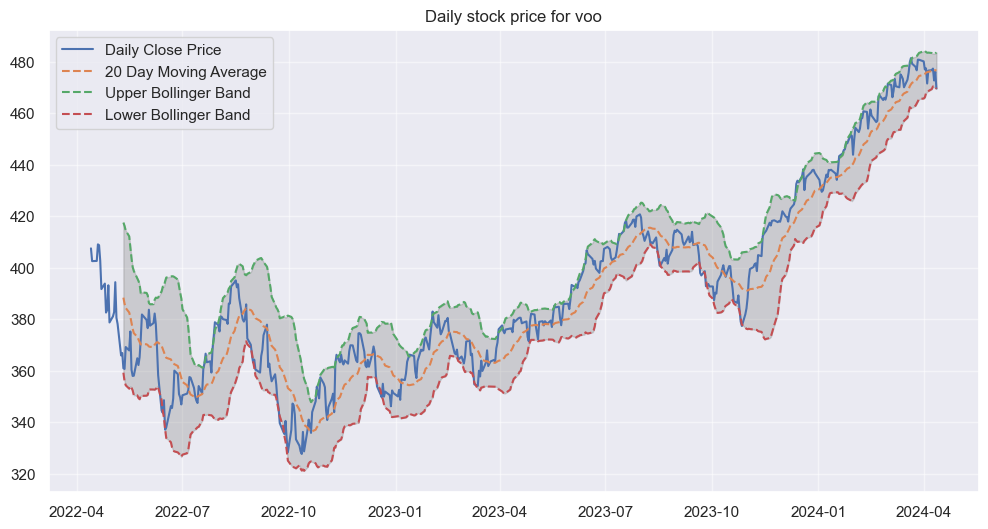

In [4]:
plot_stock('voo')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 180.33
Latest 20 Day MA: 181.6979995727539
Latest Lower Bollinger Band: 178.739966878824
Latest Higher Bollinger Band: 184.6560322666838


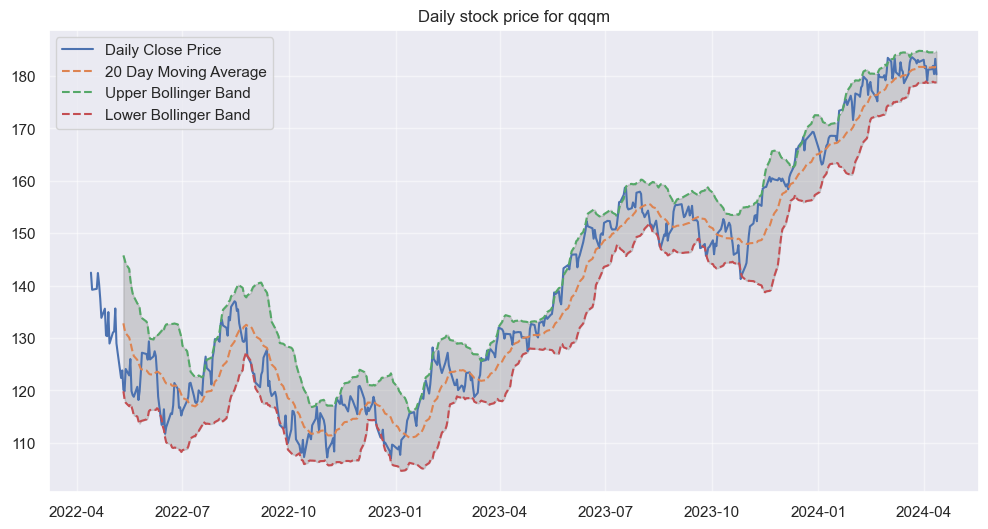

In [5]:
plot_stock('qqqm')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 403.26
Latest 20 Day MA: 413.63350067138674
Latest Lower Bollinger Band: 403.78130278009127
Latest Higher Bollinger Band: 423.4856985626822


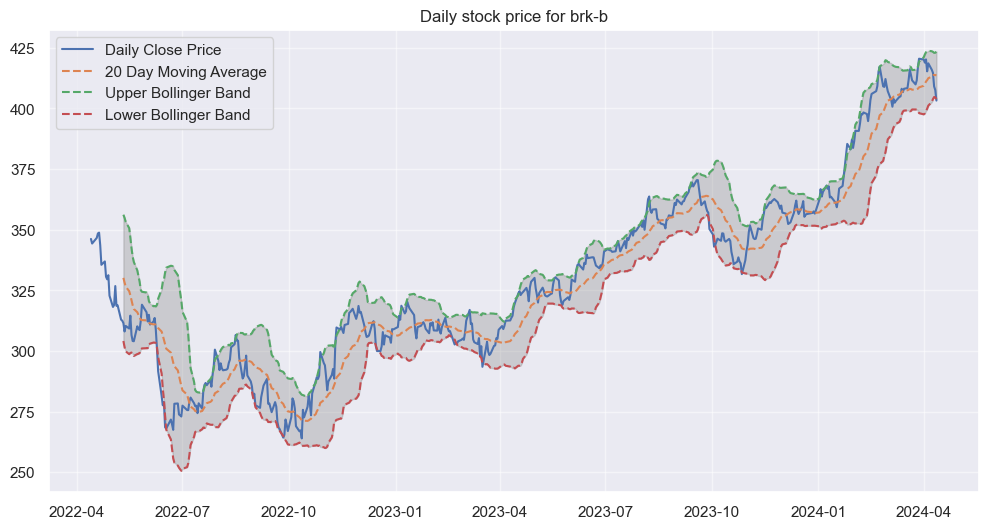

In [6]:
plot_stock('brk-b')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 410.4
Latest 20 Day MA: 426.7009994506836
Latest Lower Bollinger Band: 409.21627586317686
Latest Higher Bollinger Band: 444.1857230381903


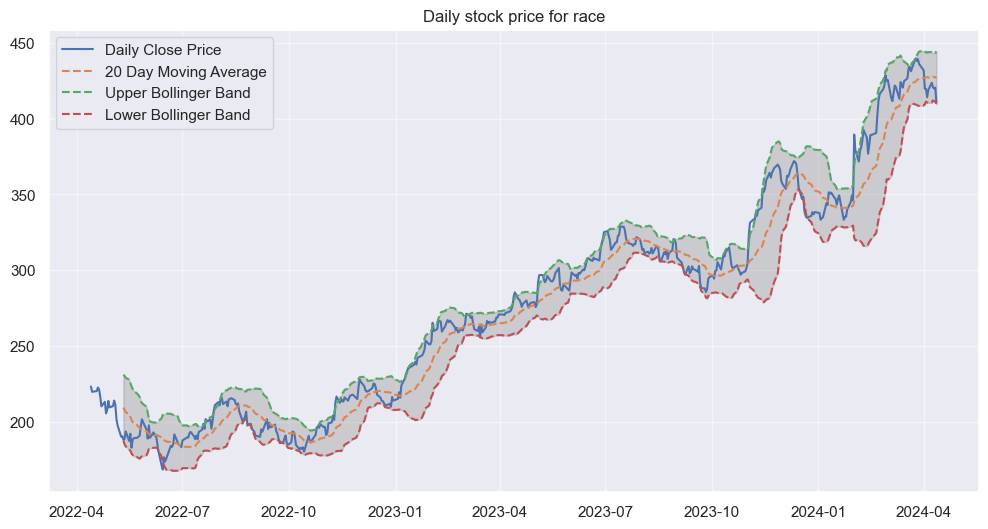

In [7]:
plot_stock('race')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 176.55
Latest 20 Day MA: 171.72499923706056
Latest Lower Bollinger Band: 165.6876476454143
Latest Higher Bollinger Band: 177.76235082870681


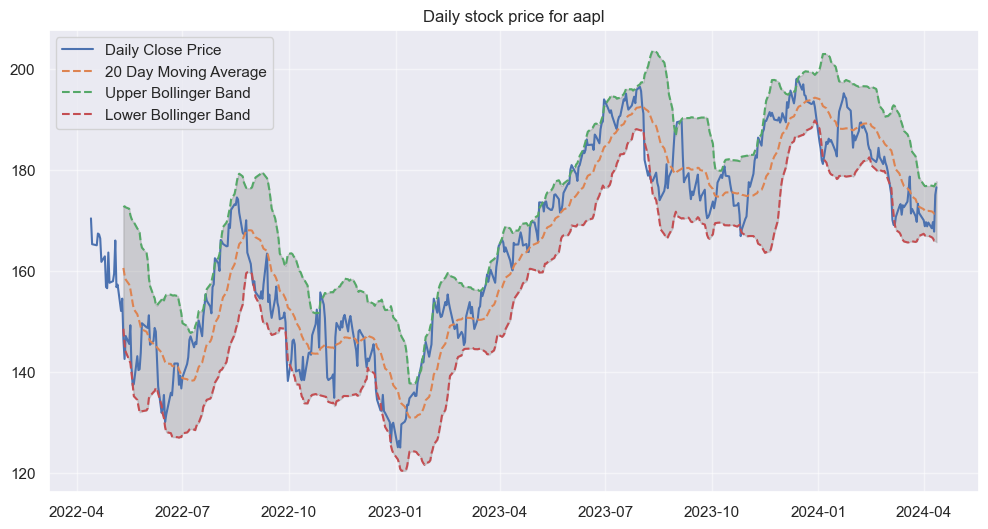

In [8]:
plot_stock('aapl')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 439.2
Latest 20 Day MA: 473.9280029296875
Latest Lower Bollinger Band: 433.3724704651002
Latest Higher Bollinger Band: 514.4835353942749


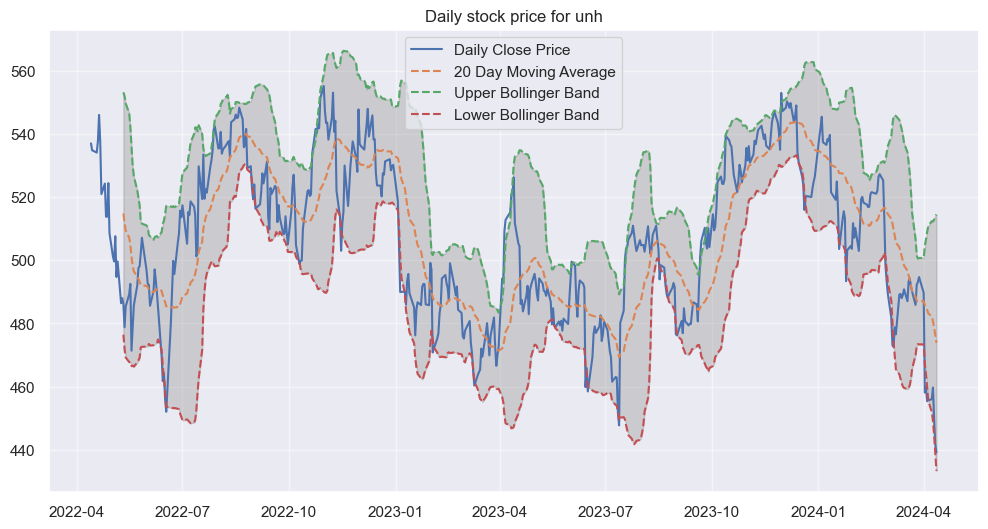

In [9]:
plot_stock('unh')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 731.31
Latest 20 Day MA: 725.3769958496093
Latest Lower Bollinger Band: 703.1608969888689
Latest Higher Bollinger Band: 747.5930947103498


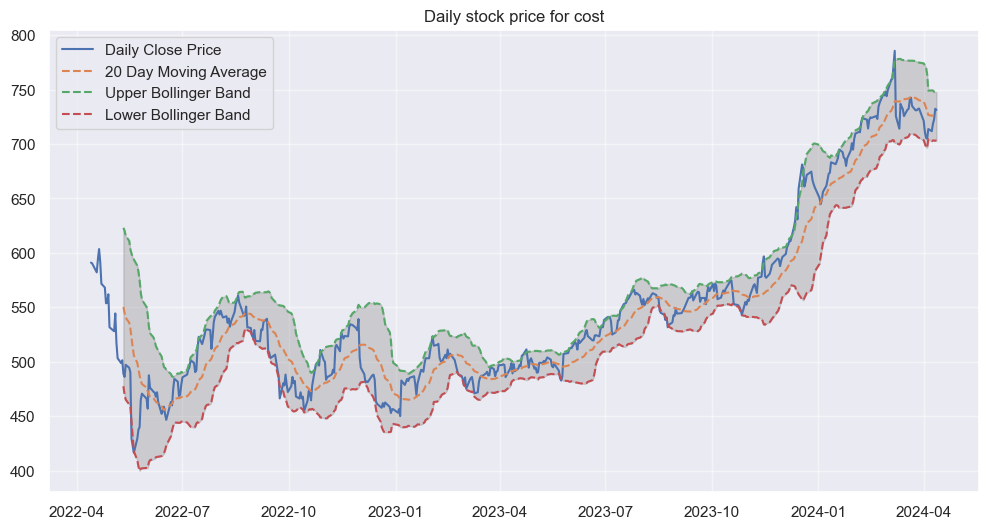

In [10]:
plot_stock('cost')

[*********************100%%**********************]  1 of 1 completed
* previous stock price closing 139.62
Latest 20 Day MA: 141.77650146484376
Latest Lower Bollinger Band: 135.30955007086433
Latest Higher Bollinger Band: 148.2434528588232


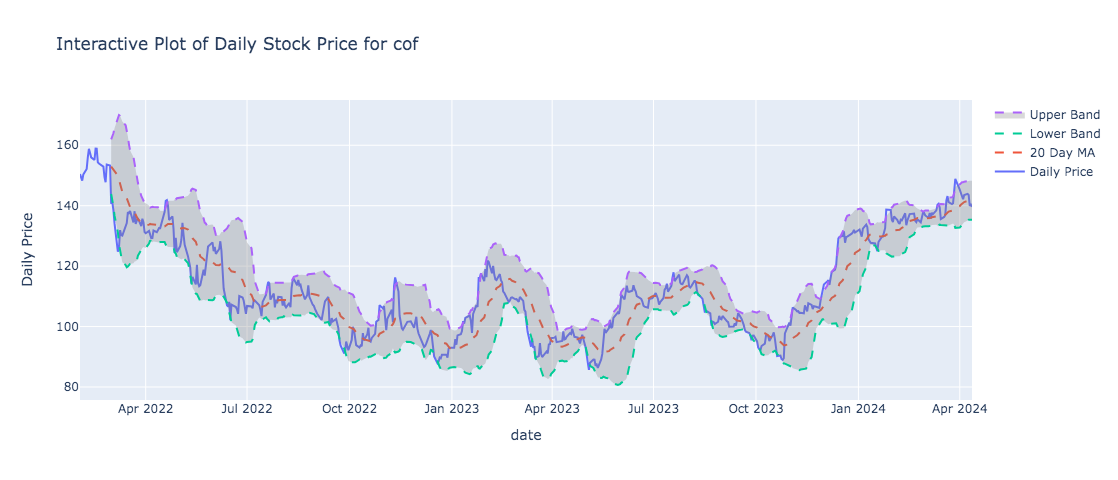

0.06159420289855073


In [11]:
df_cof = plot_stock('cof', start="2022-02-01", return_result=True, interactive=True)
print(df_cof[df_cof['close']>=df_cof['Upper Band']].shape[0] / df_cof.shape[0])

In [12]:
df_brk = yf.download('brk-b'.upper(),
                 start='2010-01-01',
                 end=datetime.today())
df_brk = df_brk.reset_index()
df_brk['log_price'] = np.log(df_brk['Close'])

df_brk.head()

[*********************100%%**********************]  1 of 1 completed


Date       Open       High        Low      Close  Adj Close   Volume  \
0 2010-01-04  66.000000  66.500000  65.919998  66.220001  66.220001  1575000   
1 2010-01-05  66.389999  66.589996  66.150002  66.540001  66.540001  1310000   
2 2010-01-06  66.500000  66.500000  66.199997  66.199997  66.199997  1760000   
3 2010-01-07  66.199997  66.510002  66.139999  66.459999  66.459999  1505000   
4 2010-01-08  66.480003  66.480003  66.300003  66.440002  66.440002  1500000   

   log_price  
0   4.192983  
1   4.197803  
2   4.192680  
3   4.196600  
4   4.196299

[1.84692442] [0.00013806]
Final price extracted: [368.5461179]


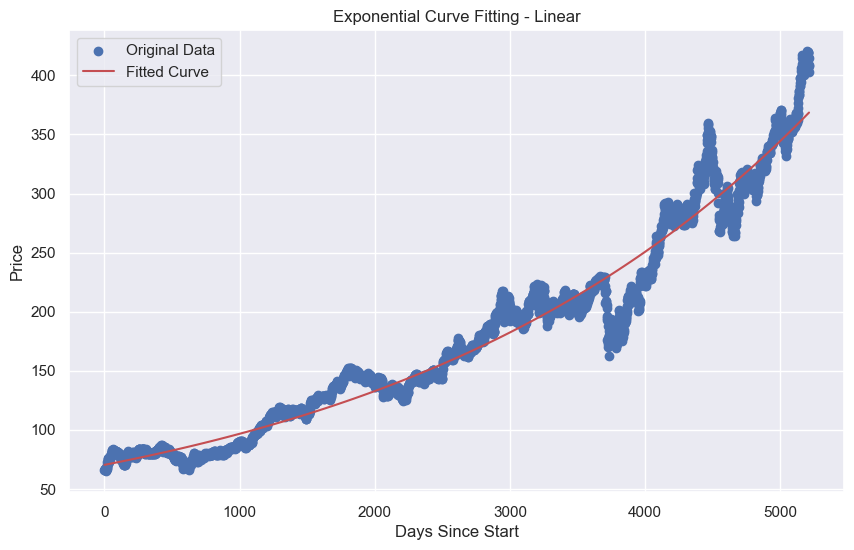

In [13]:
df_sub = df_brk.reset_index()
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

X = df_sub['days_since_start'].values.reshape(-1, 1)  # Feature matrix (date)
y = np.log10(df_sub['Close']).values.reshape(-1, 1)         # Target vector (price)

X_b = np.c_[np.ones((len(X), 1)), X]  # Add a bias term (intercept) to feature matrix
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

intercept, slope = theta_best[0], theta_best[1]

print(intercept, slope)
print('Final price extracted:',10**(intercept + slope*df_sub.tail(1)['days_since_start'].unique()[0]))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = 10**(intercept + slope*days_range)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting - Linear')
plt.legend()
plt.grid(True)
plt.show()


Annual expected return rate:  0.12330432152082316
Final price extracted: 370.1060447491477


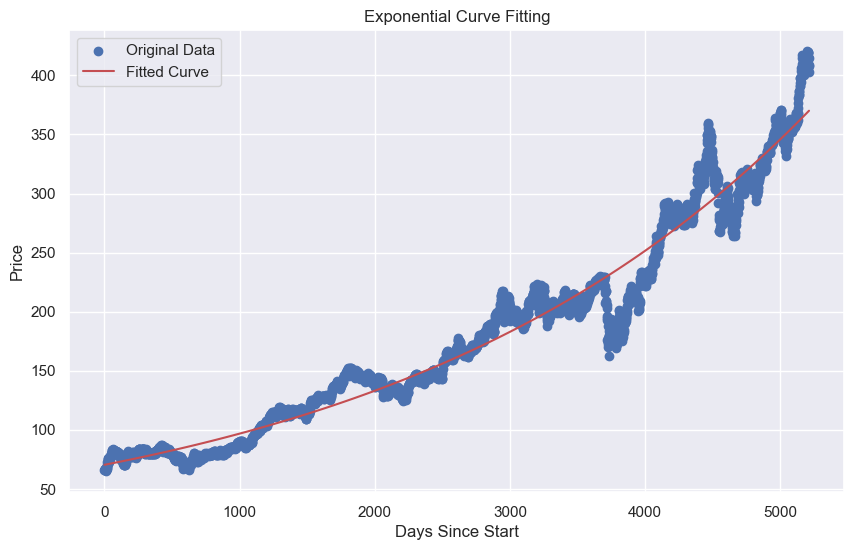

In [14]:
df_sub = df_brk.reset_index()
# df_sub = df_sub[df_sub['Date']>=pd.to_datetime('2010-01-01')]
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print('Annual expected return rate: ', 10**(b_fit*365)-1)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed
Annual expected return rate:  0.10844215948812641
Final price extracted: 453.5897627926546


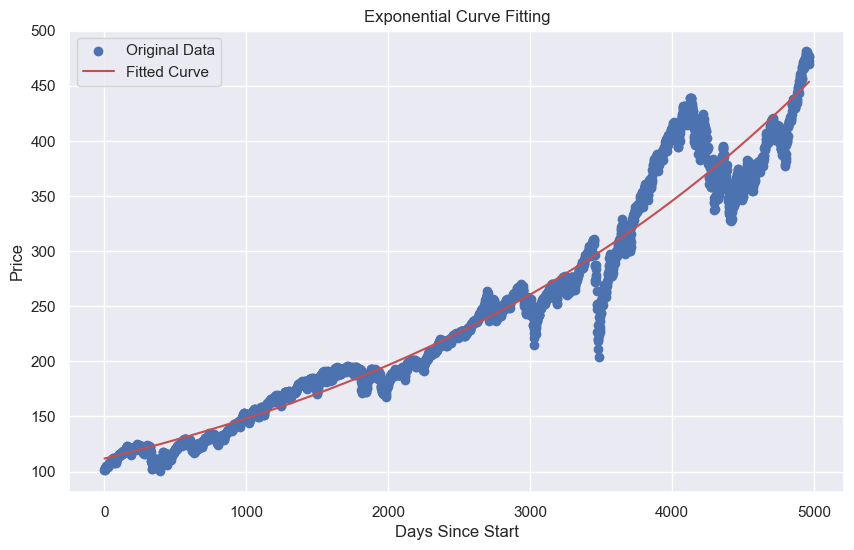

In [15]:
df_voo = yf.download('voo'.upper(),
                 start='2010-01-01',
                 end=datetime.today())
df_voo = df_voo.reset_index()
df_voo['log_price'] = np.log(df_voo['Close'])

df_sub = df_voo[df_voo['Date']>=pd.to_datetime('2010-01-01')]
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print('Annual expected return rate: ', 10**(b_fit*365)-1)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed
Annual expected return rate:  0.16932429643392166
Final price extracted: 428.6655992874135


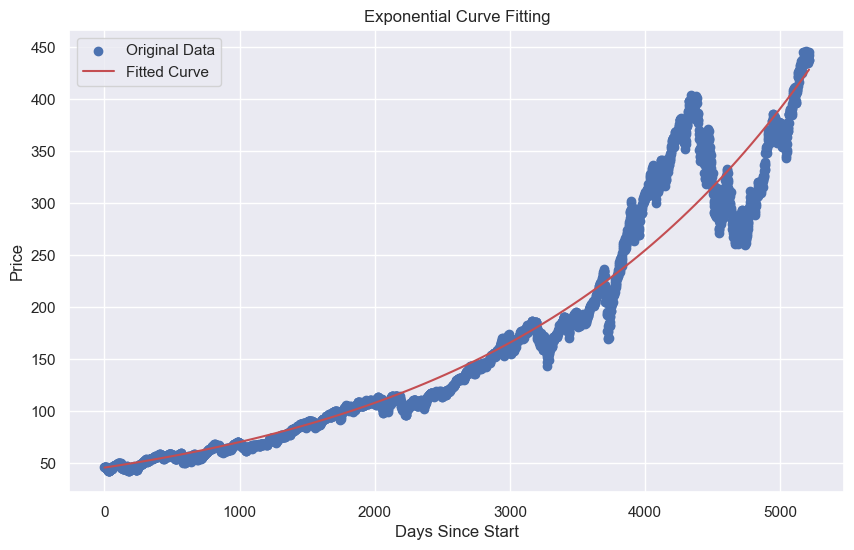

In [16]:
df_qqq = yf.download('qqq'.upper(),
                 start='2010-01-01',
                 end=datetime.today())
df_qqq = df_qqq.reset_index()
df_qqq['log_price'] = np.log(df_qqq['Close'])

df_sub = df_qqq[df_qqq['Date']>=pd.to_datetime('2010-01-01')]
df_sub['days_since_start'] = (df_sub['Date'] - df_sub['Date'].min()).dt.days

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and contains columns 'days_since_start' and 'Close'

# Define the exponential function
def exponential_func(x, a, b):
    return a * 10**(b * x)

# Initial guess for parameters
initial_guess = (df_sub.head(1)['Close'].unique()[0], np.log10(df_sub.tail(1)['Close'].unique()[0] / df_sub.head(1)['Close'].unique()[0])/df_sub.tail(1)['days_since_start'].unique()[0])  # You might need to adjust these initial values based on your data

# Fit the curve
popt, pcov = curve_fit(exponential_func, df_sub['days_since_start'], df_sub['Close'], p0=initial_guess)

a_fit, b_fit = popt
print('Annual expected return rate: ', 10**(b_fit*365)-1)
print('Final price extracted:',exponential_func(df_sub.tail(1)['days_since_start'].unique()[0],a_fit, b_fit))

# Generate the fitted curve
days_range = np.linspace(df_sub['days_since_start'].min(), df_sub['days_since_start'].max(), 100)
fitted_curve = exponential_func(days_range, *popt)

# Plot the original data and the fitted curve
plt.figure(figsize=(10, 6))
plt.scatter(df_sub['days_since_start'], df_sub['Close'], label='Original Data')
plt.plot(days_range, fitted_curve, 'r-', label='Fitted Curve')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
plt.title('Exponential Curve Fitting')
plt.legend()
plt.grid(True)
plt.show()
